In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms

from SRGAN import Generator, Discriminator
from SRGAN_data_loading import train_dataset, val_dataset, test_dataset
from SRGAN_logger import Logger, plot
from SRGAN_image_show import image_show

In [14]:
# Hyperperemeters
# num_residual_blocks = 16
batch_size = 10
lr = 0.0001
epochs = 50

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))
print(len(train_dataset[0]))

sample = train_dataset[0]  # the first sample
sample_lr, sample_hr, sample_srcnn = sample[0], sample[1], sample[2]
print(sample_lr.shape)
print(sample_hr.shape)
print(sample_srcnn.shape)
# print(sample_hr)

55
25
10
3
torch.Size([3, 128, 128])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


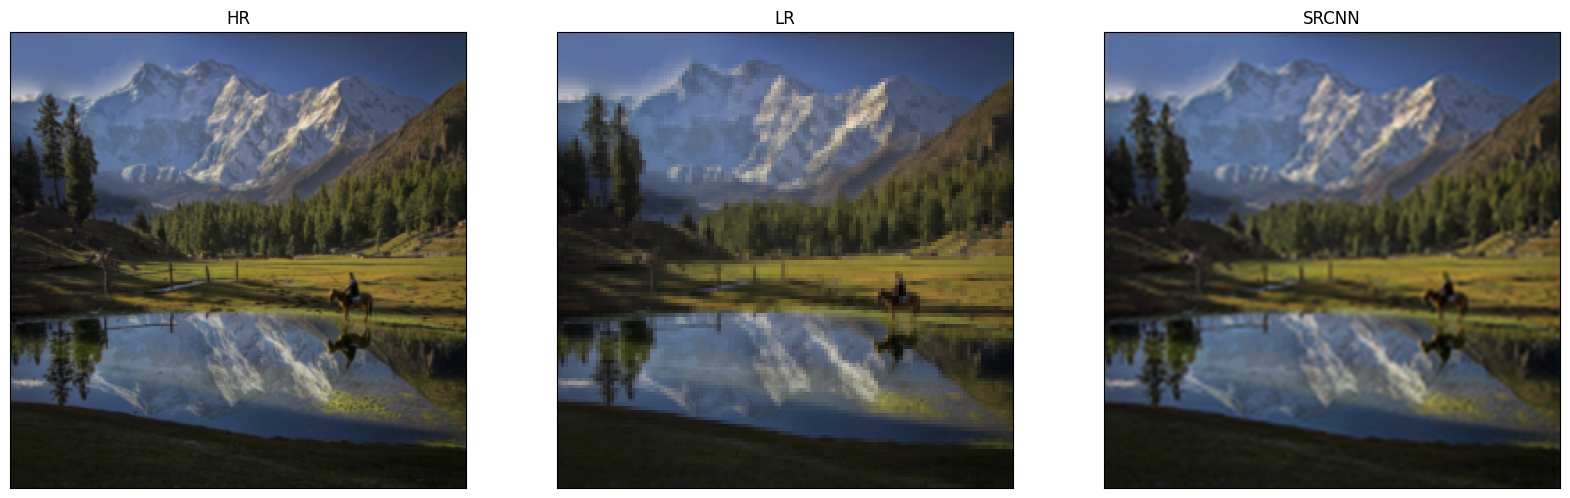

In [17]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sample_hr1 = sample_hr.permute(1, 2, 0)
sample_lr1 = sample_lr.permute(1, 2, 0)
sample_srcnn1 = sample_srcnn.permute(1, 2, 0)
axs[0].imshow(sample_hr1)
axs[1].imshow(sample_lr1)
axs[2].imshow(sample_srcnn1)
# axs[2].imshow(outputs)

axs[0].set_title('HR')
axs[1].set_title('LR')
axs[2].set_title('SRCNN')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [18]:
from skimage import color
from skimage.metrics import structural_similarity

def snr(hr_image, output_image):
    mse = np.mean((hr_image - output_image) ** 2)
    return 10 * np.log10(np.mean(hr_image ** 2) / mse)

def psnr(hr_image, output_image):
    mse = np.mean((hr_image - output_image) ** 2)
    return 10 * np.log10(1 / mse)

def ssim(hr_image, output_image, data_range):
    hr_image_gray = color.rgb2gray(hr_image)
    output_image_gray = color.rgb2gray(output_image)
    return structural_similarity(hr_image_gray, output_image_gray, data_range=data_range)

In [19]:
def evaluate(model, loader, device, test_mode = False):
    model.eval()
    snr_sum = 0
    psnr_sum = 0
    ssim_sum = 0
    num_samples = 0

    with torch.no_grad():
        for lr, hr, srcnn in loader:
            # lr = lr.to(device)
            hr = hr.to(device)
            srcnn = srcnn.to(device)

            outputs = model(srcnn)

            outputs = outputs.squeeze().cpu().permute(0, 2, 3, 1).numpy()
            hr = hr.squeeze().cpu().permute(0, 2, 3, 1).numpy()

            for i in range(hr.shape[0]):
                snr_value = snr(hr[i], outputs[i])
                psnr_value = psnr(hr[i], outputs[i])
                ssim_value = ssim(hr[i], outputs[i], data_range=outputs[i].max() - outputs[i].min())

                snr_sum += snr_value
                psnr_sum += psnr_value
                ssim_sum += ssim_value

                num_samples += 1

            if test_mode:
                lr = lr.squeeze().cpu().permute(0, 2, 3, 1).numpy()
                srcnn = srcnn.squeeze().cpu().permute(0, 2, 3, 1).numpy()
                image_show(lr[i], srcnn[i], outputs[i], hr[i])

    # Average
    snr_avg = snr_sum / num_samples
    psnr_avg = psnr_sum / num_samples
    ssim_avg = ssim_sum / num_samples

    return snr_avg, psnr_avg, ssim_avg

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps")
print(device)

cuda


In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion_content = nn.MSELoss()
criterion_adversarial = nn.BCELoss()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

scheduler_G = StepLR(optimizer_G, step_size=10, gamma=0.1)
scheduler_D = StepLR(optimizer_D, step_size=10, gamma=0.1)

model_save_dir = "saved_model"
os.makedirs(model_save_dir, exist_ok=True)
best_valid_psnr = 0
logger = Logger()

for epoch in range(epochs):
    generator.train()
    discriminator.train()

    for _, hr, lr in train_loader:  # lr = srcnn
        lr = lr.to(device)
        hr = hr.to(device)
        
        # Train Discriminator
        optimizer_D.zero_grad()

        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.zeros(batch_size).to(device)

        # Discriminator loss for real images
        real_output = discriminator(hr)
        real_loss = criterion_adversarial(real_output.squeeze(), real_labels)

        # Discriminator loss for fake images
        fake_images = generator(lr)
        fake_output = discriminator(fake_images.detach())
        fake_loss = criterion_adversarial(fake_output.squeeze(), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generator content loss
        content_loss = criterion_content(fake_images, hr)

        # Generator adversarial loss
        fake_output = discriminator(fake_images)
        adversarial_loss = criterion_adversarial(fake_output.squeeze(), real_labels)

        g_loss = content_loss + 0.001 * adversarial_loss
        g_loss.backward()
        optimizer_G.step()

    # Evaluate
    train_snr, train_psnr, train_ssim = evaluate(generator, train_loader, device, test_mode = False)
    valid_snr, valid_psnr, valid_ssim = evaluate(generator, val_loader, device, test_mode = False)

    logger.append(content_loss.item(), adversarial_loss.item(), 
                  train_snr, valid_snr, train_psnr, valid_psnr, train_ssim, valid_ssim)
    print(f"Epoch [{epoch + 1}/{epochs}]",
          "Content Loss: %.4f" % content_loss.item(), "Adversarial Loss: %.4f; " % adversarial_loss.item(),
          "Train SNR: %.4f" % train_snr, "Valid SNR: %.4f; " % valid_snr,
          "Train PSNR: %.4f" % train_psnr, "Valid PSNR: %.4f; " % valid_psnr,
          "Train SSIM: %.4f" % train_ssim, "Valid SSIM: %.4f" % valid_ssim)

    if valid_psnr > best_valid_psnr:
        best_valid_psnr = valid_psnr
        model_save_path = os.path.join(model_save_dir, "best_SRGAN_generator.pth")
        torch.save(generator.state_dict(), model_save_path)
        print(f"Model Update: New PSNR: {best_valid_psnr}")

    scheduler_G.step()
    scheduler_D.step()

In [ ]:
logger.save_to_csv("training_data_SRGAN.csv")
plot(logger)

In [ ]:
# from image_show import image_show
model_test = Generator().to(device)
model_test.load_state_dict(torch.load("./saved_model/best_SRGAN_generator.pth"))

snr_avg, psnr_avg, ssim_avg = evaluate(model_test, test_loader, device, test_mode = True)
print(f"Test:\n SNR: {snr_avg:.4f}, PSNR: {psnr_avg:.4f}, SSIM: {ssim_avg:.4f}")

In [ ]:
import cv2
from torchvision.transforms.functional import resize
from PIL import Image

root_dir = './data'

model_confirm = generator().to(device)
model_confirm.load_state_dict(torch.load("./saved_model/best_SRGAN_generator.pth"))
model_confirm.eval()

transform = transforms.Compose([transforms.ToTensor()])

for phase in ['train', 'val', 'test']:
    lr_folder = os.path.join(root_dir, phase, 'SRCNN')
    output_folder = os.path.join(root_dir, phase, 'SRGAN')

    os.makedirs(output_folder, exist_ok=True)

    lr_images = os.listdir(lr_folder)
    lr_images.sort()

    for lr_image_name in lr_images:
        lr_image_path = os.path.join(lr_folder, lr_image_name)

        lr_image = Image.open(lr_image_path).convert('RGB')
        # lr_image = resize(lr_image, (128, 128))
        lr_tensor = transform(lr_image).unsqueeze(0)

        with torch.no_grad():
            lr_tensor = lr_tensor.to(device)
            sr_tensor = model_confirm(lr_tensor)

        sr_image_np = sr_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        sr_image_np = (sr_image_np * 255).clip(0, 255).astype(np.uint8)

        sr_image_bgr = cv2.cvtColor(sr_image_np, cv2.COLOR_RGB2BGR)

        cv2.imwrite(os.path.join(output_folder, lr_image_name), sr_image_bgr)

print("SRGAN process completed.")